# Exam exercise

This exercise is in two parts, using datasets we've seen already.

1. Go back to the "Time transients" problem from lecture 5. There we fitted two models, an exponential tail and a gaussian.
 - Fit the same models again using nested sampling
 - Compare the parameter-estimation results against those you got with MCMCs. They should be compatible
 - Evaluate the Bayes factor between the two models and interpret it using the Jeffrey's scale. 
 
2. Go back to the "Higgs boson" problem from lecture 6. There we had two nested models and computed the evidence using Savage Dickey.
 - Fit the same models again using nested sampling.
 - Evaluate the Bayes factor between the two models and interpret it using the Jeffrey's scale. 
 - Is this compatible with your previous estimate? 


### Time transients

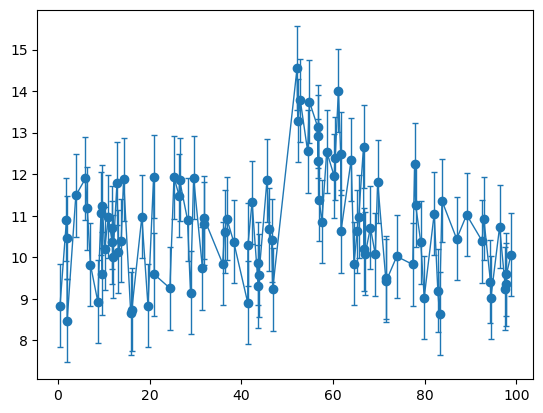

In [2]:
import matplotlib.pyplot as plt
import numpy as np

tt_array = np.load("datasets/transient.npy")

plt.errorbar(tt_array[..., 0], tt_array[...,1], tt_array[...,2], marker='o', linewidth=1, capsize=2)
plt.show()

In [3]:
print(tt_array[..., 2])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [4]:
def burst_model(x, x_0, background_amp, burst_amp, alpha):
    return np.where(
        x < x_0,
        background_amp,
        background_amp + burst_amp * np.exp(-alpha * (x - x_0))
    )

def burst_log_likelihood(theta, x, y, yerr):
    x_0, background_amp, burst_amp, alpha = theta
    model = burst_model(x, x_0, background_amp, burst_amp, alpha)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

In [5]:
def prior_transform(u):
    # u is a unit cube, whose each dimension is in [0, 1]
    b = u[0] * 50
    A = u[1] * 50
    t = u[2] * 100
    ln_alpha = u[3] * 10 - 5
    return np.array([t, b, A, np.exp(ln_alpha)])  # x_0, background_amp, burst_amp, alpha

In [6]:
import dynesty
import dynesty.plotting as dyplot

sampler = dynesty.NestedSampler(burst_log_likelihood, prior_transform, ndim=4, 
                                logl_args=(tt_array[..., 0], tt_array[..., 1], tt_array[..., 2]),
                                nlive=1000)
sampler.run_nested()
sresults_1 = sampler.results

C:\Users\andre\AppData\Local\Temp\ipykernel_216472\3034294600.py:5: RuntimeWarning: overflow encountered in exp
  background_amp + burst_amp * np.exp(-alpha * (x - x_0))
C:\Users\andre\AppData\Local\Temp\ipykernel_216472\3034294600.py:5: RuntimeWarning: overflow encountered in multiply
  background_amp + burst_amp * np.exp(-alpha * (x - x_0))
1701it [00:01, 1029.55it/s, bound: 0 | nc: 47 | ncall: 15160 | eff(%): 11.220 | loglstar:   -inf < -202.784 <    inf | logz: -211.179 +/-  0.124 | dlogz: 139.387 >  0.509]  C:\Users\andre\AppData\Local\Temp\ipykernel_216472\3034294600.py:5: RuntimeWarning: overflow encountered in exp
  background_amp + burst_amp * np.exp(-alpha * (x - x_0))
1818it [00:01, 617.70it/s, bound: 1 | nc: 1 | ncall: 18071 | eff(%): 10.060 | loglstar:   -inf < -164.651 <    inf | logz: -173.417 +/-  0.124 | dlogz: 101.487 >  0.509]  C:\Users\andre\AppData\Local\Temp\ipykernel_216472\3034294600.py:5: RuntimeWarning: overflow encountered in multiply
  background_amp + burst

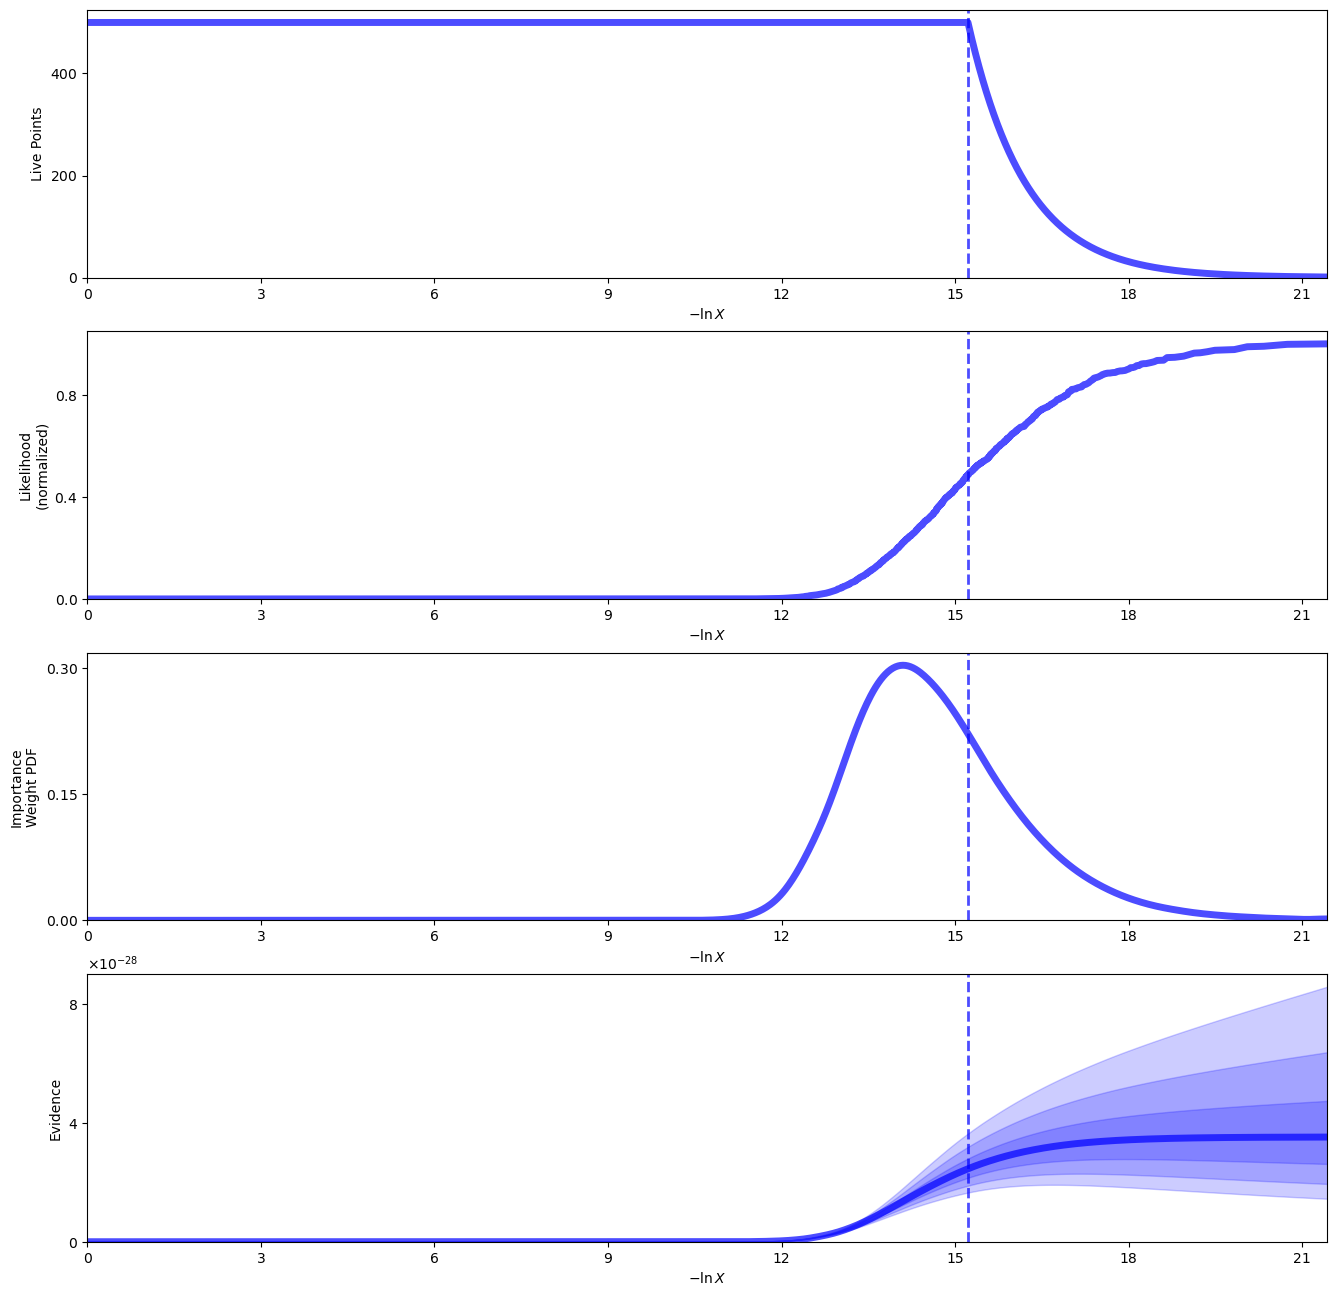

In [13]:
rfig, raxes = dyplot.runplot(sresults_1)

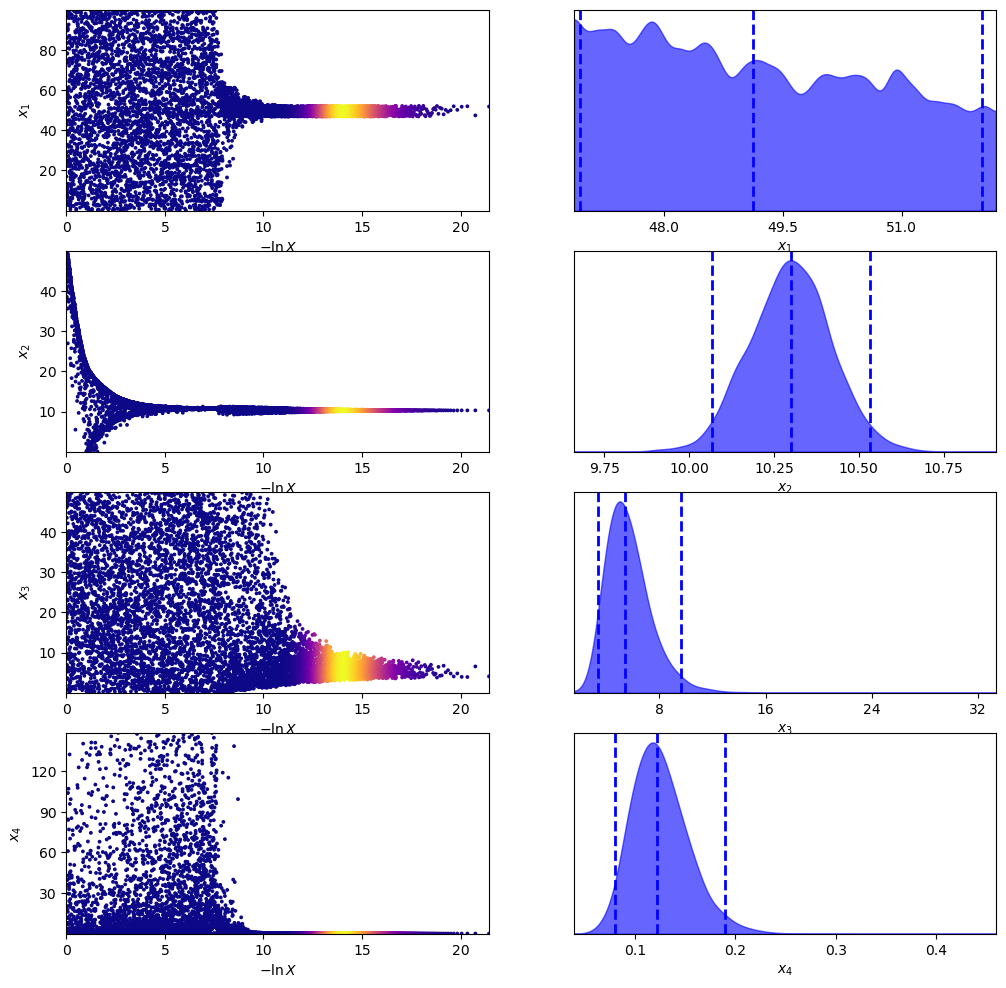

In [14]:
tfig, taxes = dyplot.traceplot(sresults_1)

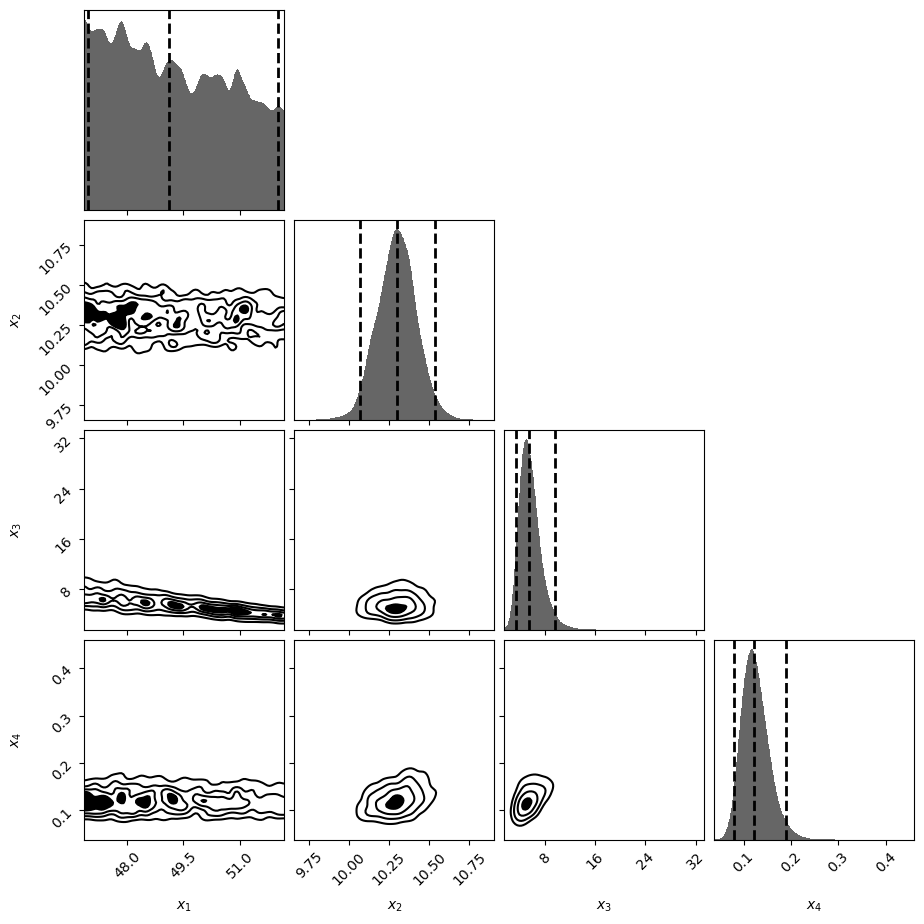

In [9]:
cfig, caxes = dyplot.cornerplot(sresults_1)

#### Parameters mean and std

In [10]:
samples = sresults_1.samples
weights = np.exp(sresults_1.logwt - sresults_1.logz[-1])

mean = np.average(samples, weights=weights, axis=0)
std = np.sqrt(np.average((samples - mean)**2, weights=weights, axis=0))

x_0_mean, bkg_amp_mean, burst_amp_mean, alpha_mean = mean
x_0_std, bkg_amp_std, burst_amp_std, alpha_std = std

print(f"x_0: {x_0_mean:.2f} ± {x_0_std:.2f}")
print(f"background_amp: {bkg_amp_mean:.2f} ± {bkg_amp_std:.2f}")
print(f"burst_amp: {burst_amp_mean:.2f} ± {burst_amp_std:.2f}")
print(f"alpha: {alpha_mean:.2f} ± {alpha_std:.2f}")

x_0: 49.26 ± 1.52
background_amp: 10.30 ± 0.12
burst_amp: 5.68 ± 1.65
alpha: 0.13 ± 0.03


The results are compatible with the posterior found by the MCMC.

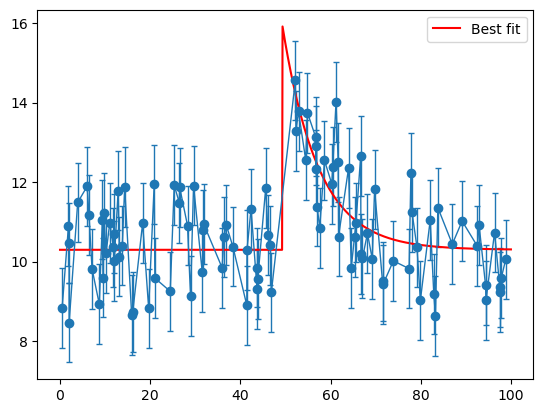

In [11]:
plt.errorbar(tt_array[..., 0], tt_array[...,1], tt_array[...,2], marker='o', linewidth=1, capsize=2)
x = np.linspace(0, 100, 1000)
plt.plot(x, burst_model(x, x_0_mean, bkg_amp_mean, burst_amp_mean, alpha_mean), label='Best fit', color='red')
plt.legend()

The Bayes factor is the ratio of the two model's evidence, or marginal likelihood. MCMC does not give the evidence, so what does the question want?

Maybe the question refers to the two models in the `TimeTransients` notebook. We can definitely compute the Bayes factor between two nested model.

#### Bayes Factor for Time Transients

In [17]:
def gaussian_model(x, x_0, background_amp, burst_amp, sigma):
    return background_amp + burst_amp * np.exp(-((x - x_0)**2 / 2 * sigma**2))

def gaussian_log_likelihood(theta, x, y, yerr):
    x_0, background_amp, burst_amp, sigma = theta
    model = gaussian_model(x, x_0, background_amp, burst_amp, sigma)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

def prior_transform(u):
    # u is a unit cube, whose each dimension is in [0, 1]
    b = u[0] * 20
    A = (u[1] * 4) + 2
    t = (u[2] * 50) + 30
    sigma = u[3] * 5
    return np.array([t, b, A, sigma])

sampler = dynesty.NestedSampler(gaussian_log_likelihood, prior_transform, ndim=4, logl_args=(tt_array[..., 0], tt_array[..., 1], tt_array[..., 2]))
sampler.run_nested()
sresults_2 = sampler.results

0it [00:00, ?it/s]

2895it [00:23, 73.53it/s, bound: 44 | nc: 20 | ncall: 50217 | eff(%):  5.765 | loglstar:   -inf < -82.230 <    inf | logz: -89.789 +/-  0.112 | dlogz: 28.585 >  0.509]   c:\Users\andre\miniforge3\envs\astronomy\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2909it [00:23, 59.68it/s, bound: 45 | nc: 113 | ncall: 50602 | eff(%):  5.749 | loglstar:   -inf < -82.097 <    inf | logz: -89.628 +/-  0.112 | dlogz: 28.396 >  0.509]c:\Users\andre\miniforge3\envs\astronomy\Lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is 

In [18]:
log_evidence_1 = sresults_1.logz[-1]
log_evidence_2 = sresults_2.logz[-1]

bayes_factor = np.exp(log_evidence_1 - log_evidence_2)
print(f"Bayes factor in favor of Model 1 against Model 2: {bayes_factor}")

Bayes factor in favor of Model 1 against Model 2: 10.697280642444303


With a Bayes factor of ~10, we have strong evidence that the burst model is preferrable over the Gaussian one. 

### Higgs Boson

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def hb_model(x, a, k, x_0, amp, mu, sigma):
    delta_x = np.clip(x - x_0, 1e-6, None)
    background = a * delta_x**(-k)
    signal = amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return background + signal

def hb_log_likelihood(theta, x, y, yerr):
    a, k, x_0, amp, mu, sigma = theta
    model = hb_model(x, a, k, x_0, amp, mu, sigma)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

In [32]:
from scipy.stats import norm, halfnorm

def prior_transform(u):
    # u is a unit cube, whose each dimension is in [0, 1]
    a = halfnorm(scale=10).ppf(u[0])
    k = norm(loc=2, scale=1).ppf(u[1])
    x_0 = norm(loc=110, scale=5).ppf(u[2])
    amp = norm(loc=0, scale=5).ppf(u[3])
    mu = norm(loc=125, scale=0.5).ppf(u[4])
    sigma = halfnorm(scale=0.8).ppf(u[5])
    return np.array([a, k, x_0, amp, mu, sigma])

In [ ]:
import dynesty
import dynesty.plotting as dyplot

data = np.loadtxt('datasets/boson.txt', unpack=True)
x_values = data[0] 
y_values = data[1]
errs_values = data[2]

sampler = dynesty.NestedSampler(hb_log_likelihood, prior_transform, 
                                ndim=6, logl_args=(x_values, y_values, errs_values),
                                sample='rwalk', nlive=100) # Takes too long otherwise
sampler.run_nested()
sresults = sampler.results

4412it [08:54,  8.25it/s, +100 | bound: 277 | nc: 1 | ncall: 109490 | eff(%):  4.125 | loglstar:   -inf < -20.172 <    inf | logz: -61.902 +/-    nan | dlogz:  0.001 >  0.109]


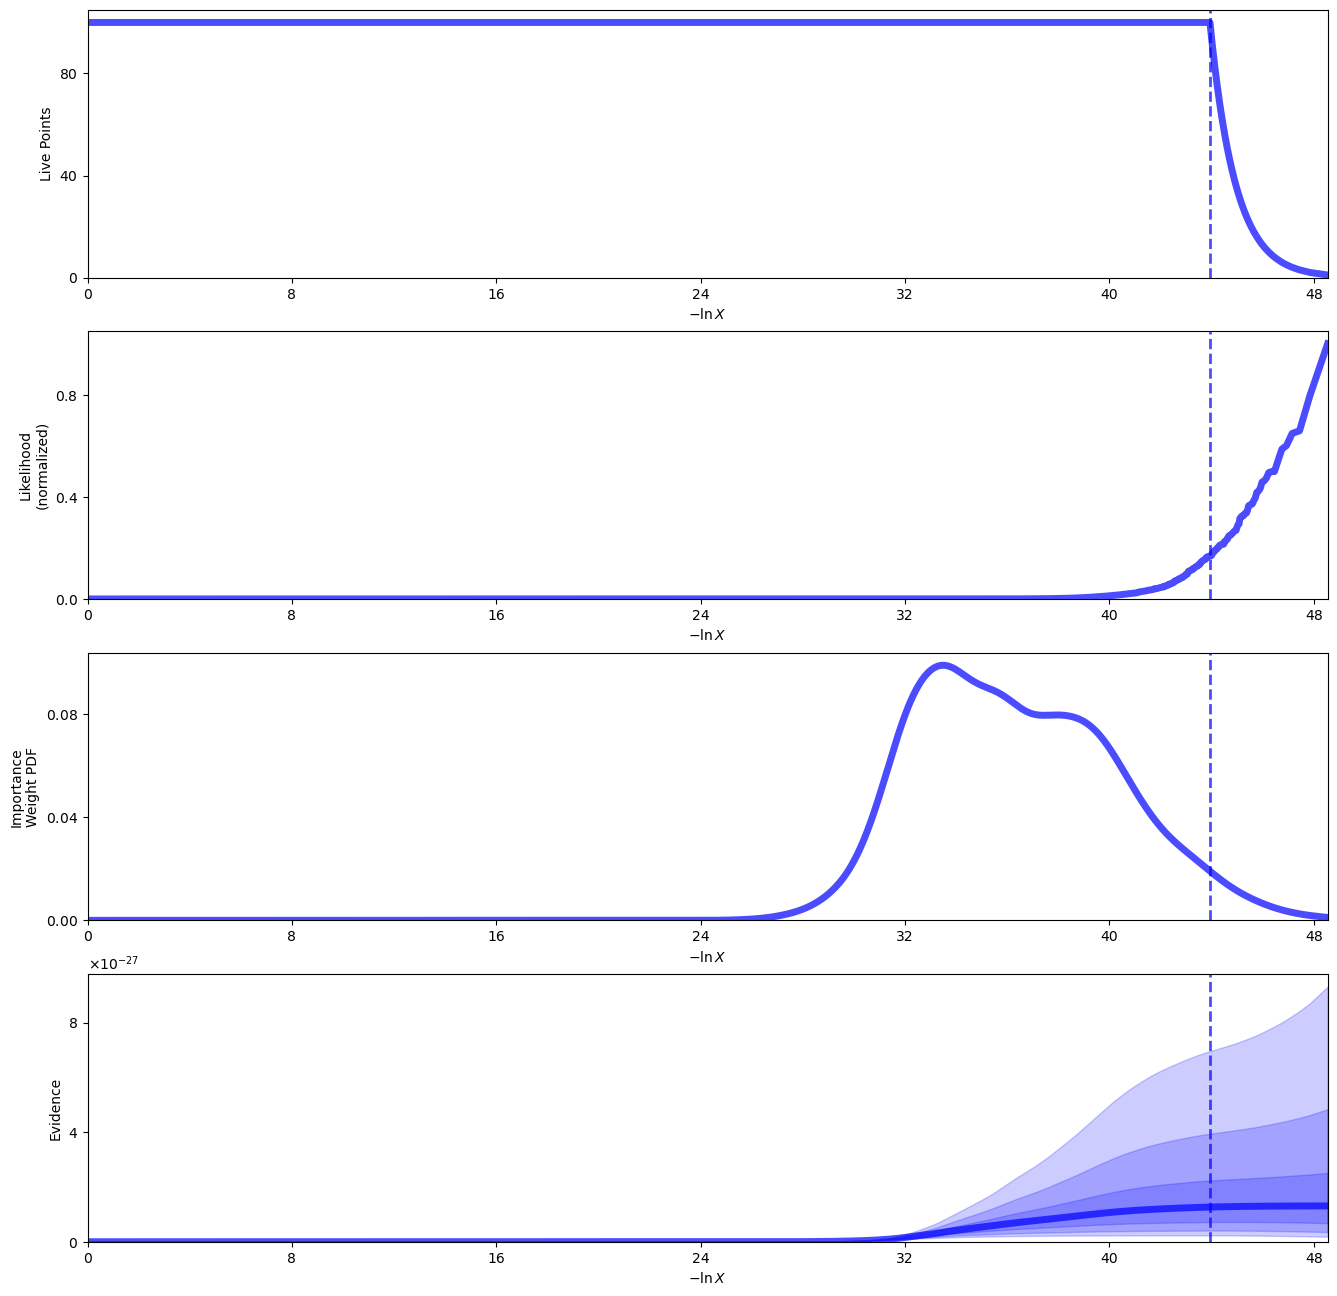

In [34]:
rfig, raxes = dyplot.runplot(sresults)

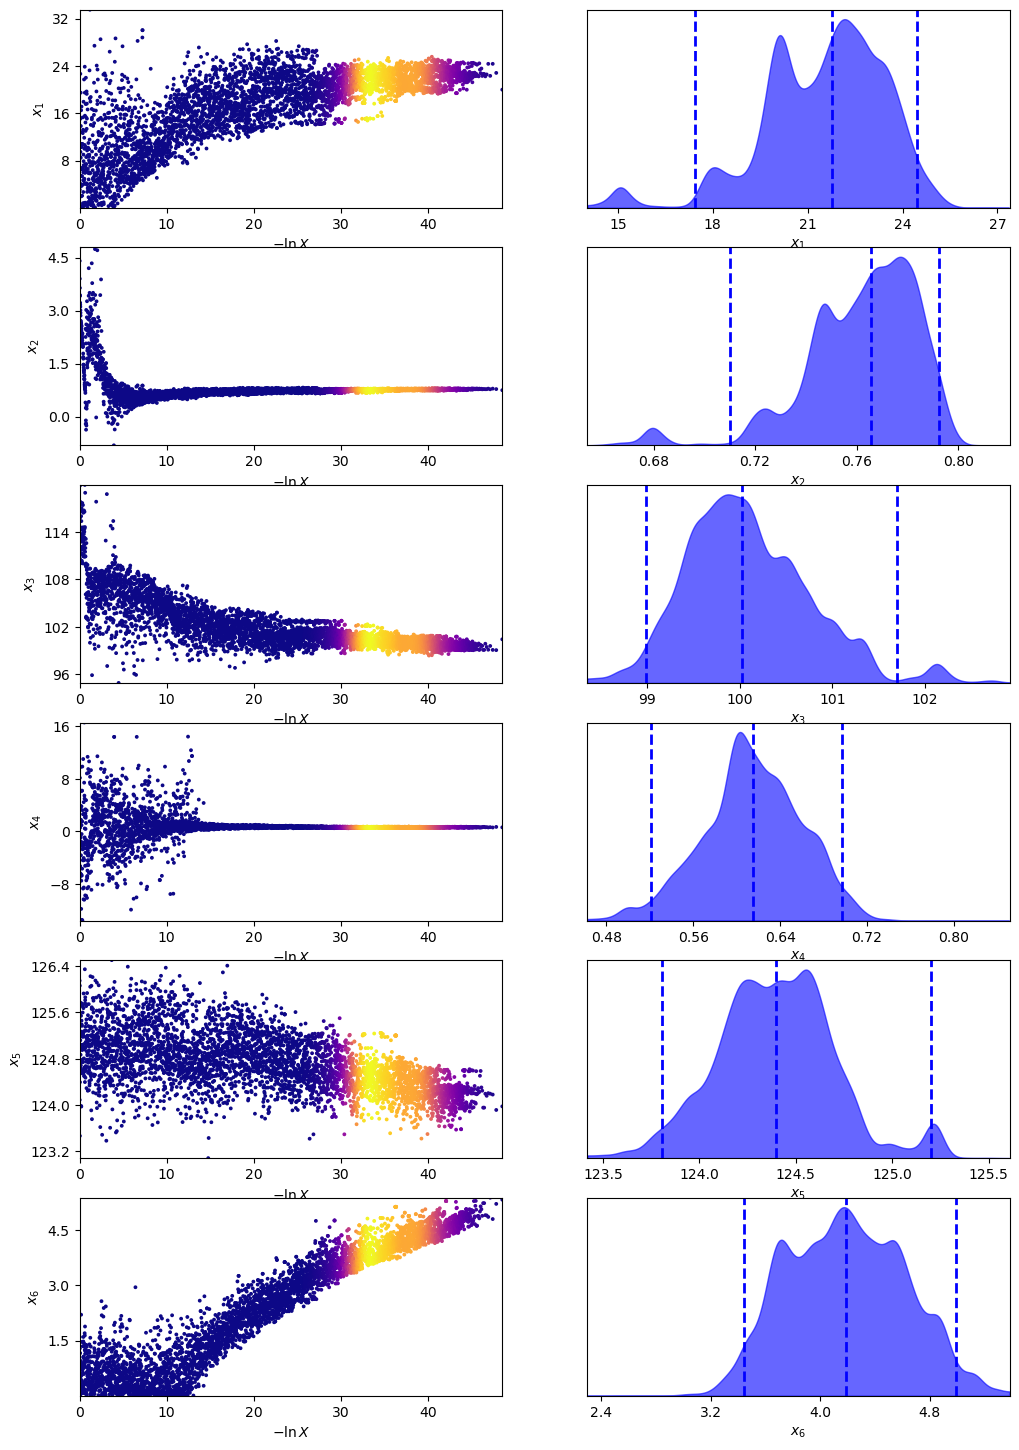

In [35]:
tfig, taxes = dyplot.traceplot(sresults)

In [36]:
samples = sresults.samples
weights = np.exp(sresults.logwt - sresults.logz[-1])

mean = np.average(samples, weights=weights, axis=0)
std = np.sqrt(np.average((samples - mean)**2, weights=weights, axis=0))

a_mean, k_mean, x_0_mean, amp_mean, mu_mean, sigma_mean = mean
a_std, k_std, x_0_std, amp_std, mu_std, sigma_std = std

print(f"a: {a_mean:.2f} ± {a_std:.2f}")
print(f"k: {k_mean:.2f} ± {k_std:.2f}")
print(f"x_0: {x_0_mean:.2f} ± {x_0_std:.2f}")
print(f"amp: {amp_mean:.2f} ± {amp_std:.2f}")
print(f"mu: {mu_mean:.2f} ± {mu_std:.2f}")
print(f"sigma: {sigma_mean:.2f} ± {sigma_std:.2f}")

a: 21.49 ± 1.93
k: 0.76 ± 0.02
x_0: 100.10 ± 0.68
amp: 0.61 ± 0.04
mu: 124.40 ± 0.31
sigma: 4.19 ± 0.43


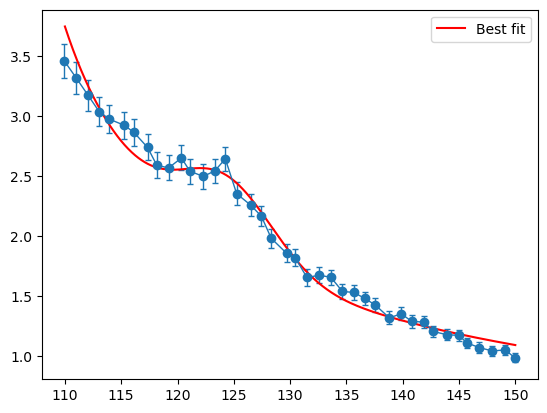

In [37]:
plt.errorbar(x_values, y_values, errs_values, marker='o', linewidth=1, capsize=2)
x = np.linspace(110, 150, 1000)
plt.plot(x, hb_model(x, a_mean, k_mean, x_0_mean, amp_mean, mu_mean, sigma_mean), label='Best fit', color='red')
plt.legend()

A little bit off from the MCMC model, but still, it fits quite well. Now, following what we did for time transients, we'd expect to compare this with another model. The other model though is the one assuming signal = 0.

In [38]:
sresults_3 = sresults

In [40]:
def no_sig_model(x, a, k, x_0):
    delta_x = np.clip(x - x_0, 1e-6, None)
    background = a * delta_x**(-k)
    return background

def no_sig_log_likelihood(theta, x, y, yerr):
    a, k, x_0 = theta
    model = no_sig_model(x, a, k, x_0)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

def prior_transform(u):
    # u is a unit cube, whose each dimension is in [0, 1]
    a = halfnorm(scale=10).ppf(u[0])
    k = norm(loc=2, scale=1).ppf(u[1])
    x_0 = norm(loc=110, scale=5).ppf(u[2])
    return np.array([a, k, x_0])

sampler = dynesty.NestedSampler(no_sig_log_likelihood, prior_transform, 
                                ndim=3, logl_args=(x_values, y_values, errs_values)) # We can afford it now
sampler.run_nested()
sresults_4 = sampler.results

14728it [04:18, 57.07it/s, +500 | bound: 76 | nc: 1 | ncall: 75733 | eff(%): 20.241 | loglstar:   -inf < -100.907 <    inf | logz: -129.771 +/-    nan | dlogz:  0.001 >  0.509]


In [42]:
log_evidence_3 = sresults_3.logz[-1]
log_evidence_4 = sresults_4.logz[-1]

bayes_factor = np.exp(log_evidence_3 - log_evidence_4)
print(f"Bayes factor in favor of the signal: {bayes_factor}")

Bayes factor in favor of the signal: 2.9857825890869014e+29


Just as we found out in `HiggsBoson.ipynb`, the presence of the signal is heavily supported. A Bayes factor greater than 100 is considered decisive. 

This result is in line with what we discovered in the dedicated notebook.